# Homework 5

In [1]:
using Plots
using LinearAlgebra
using ForwardDiff
using LaTeXStrings

In [2]:
# Functions

# Quadratic function
f(x) = x^2
∇f(x) = 2*x

# Rosenbrock function
f_r(x; a=1, b=5) = (a - x[1]) ^ 2 + b * (x[2] - x[1] ^ 2) ^ 2
∇f_r(x) = [20 * x[1] ^ 3 + (2 - 20 * x[2]) * x[1] - 2, 
           10 * (x[2] - x[1] ^ 2)]

∇f_r (generic function with 1 method)

In [3]:
# Plot Rosenbrock

function rosenplot()
    _f(x, y; a=1., b=5.) = (a-x)^2 + b*(y-x^2)^2
    x, y = -3:0.01:3, -3:0.01:3
    contour(x, y, _f,
            size=(500, 500),
            #framestyle=:box,
            color=cgrad(:viridis, rev=true),
            levels=collect(2 .^(0:7)),
            legend=true,
            xlims=(-3, 3),
            ylims=(-3, 3),
            grid=false,
            ticks=true,)
end

rosenplot (generic function with 1 method)

In [4]:
function line_search(f, grad, x, d; α=5, β=1e-4, σ=0.1, max_iter=20)
    y0, g0, y_prev, α_prev = f(x)[1], grad(x)⋅d, NaN, 0
    αlo, αhi = NaN, NaN
    
    # Bracket phase
    while true
        y = f(x+α*d)[1]
        if y > y0 + β*α*g0 || (!isnan(y_prev) && y >= y_prev)
            αlo, αhi = α_prev, α
            break
        end
        
        g = grad(x+α*d)⋅d
        if abs(g) <= -σ*g0
            return α
        elseif g >= 0
            αlo, αhi = α, α_prev
            break
        end
        y_prev, α_prev, α = y, α, 2α
    end
    
    # Zoom phase
    ylo = f(x + αlo*d)[1]
    n = 0
    while n < max_iter
        α = (αlo + αhi)/2
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || y >= ylo
            αhi = α
        else
            g = grad(x + α*d)⋅d
            if abs(g) <= -σ*g0
                return α
            elseif g*(αhi - αlo) >= 0
                αhi = αlo
            end
            αlo = α
        end
        n += 1
    end
end

line_search (generic function with 1 method)

# Steepest Descent

In [5]:
abstract type DescentMethod end
mutable struct GradientDescent <: DescentMethod
    x
    α
    g
end

In [6]:
function step!(M::GradientDescent, f, ∇f, linesearch=false)
    M.g = -∇f(M.x)
    d = M.g / norm(M.g)
    if linesearch
        M.α = line_search(f, ∇f, M.x, d)
    end
    M.x += M.α*d
    return M.x, d
end

step! (generic function with 2 methods)

In [7]:
function optimize(M::GradientDescent, f, ∇f, line_search=true, f_tol=1e-10, g_tol=1e-2, max_iter=1000)
    x = rand(1, length(M.x))
    for (i, m) in enumerate(M.x)
        x[i] = m
    end
    
    for i in 1:max_iter
        x_prev = M.x
        step!(M::GradientDescent, f, ∇f, line_search)
        x = [x; (M.x)'] # prime is for Transpose
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return x
end

optimize (generic function with 5 methods)

Terminate due to gradient tolerance


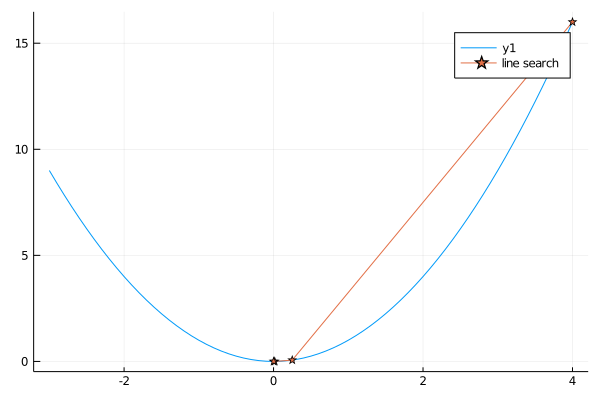

In [8]:
x0 = 4.
M = GradientDescent(x0, 0.5, 0)
xs = optimize(M, f, ∇f, true)

x = -3:.1:4
y = -3:.1:4
plot(x, f)
plot!(xs[:], f, m=:s, label="line search")

# Conjugate Gradient

In [9]:
mutable struct ConjugateGradientDescent <: DescentMethod
    x 
    α
    d #direction
    g
end

In [10]:
function step!(M::ConjugateGradientDescent, f, ∇f, linesearch)
    d, g = M.d, M.g
    g′ = ∇f(M.x)
    β = max(0, dot(g′, g′-g)/(g⋅g)) 
    d′ = -g′ + β*d
    if linesearch #variable alpha
        M.α = line_search(f, ∇f, M.x, d′)
    end
    M.x += M.α*d′
    M.d, M.g = d′, g′
end

step! (generic function with 3 methods)

In [11]:
function optimize(M::ConjugateGradientDescent, f, ∇f, line_search=true, f_tol=1e-10, g_tol=1e-2, max_iter=1000)
    xs = rand(1, length(M.x))
    for (i, m) in enumerate(M.x)
        xs[i] = m
    end
    for i in 1:max_iter
        x_prev = M.x
        step!(M::ConjugateGradientDescent, f, ∇f, line_search)
        xs = [xs; (M.x)']
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

optimize (generic function with 10 methods)

Terminate due to gradient tolerance
Terminate due to gradient tolerance


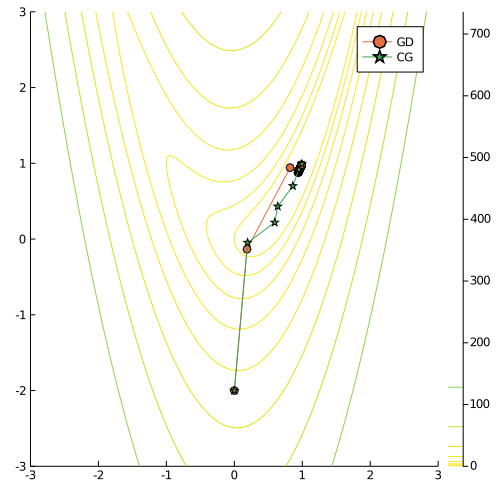

In [12]:
# Rosen GD vs CG
gr(dpi=100)

x0 = [0, -2]

M1 = GradientDescent(x0, 0.5, 0.)
x_GD = optimize(M1, f_r, ∇f_r, true)

M2 = ConjugateGradientDescent(x0, 0.5, -∇f_r(x0), ∇f_r(x0))
x_CG = optimize(M2, f_r, ∇f_r, true)

rosenplot()
plot!(x_GD[:,1], x_GD[:,2], m=:o, label="GD")
plot!(x_CG[:,1], x_CG[:,2], m=:s, label="CG")